In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flaremodel as fm

#import os; os.environ["OMP_NUM_THREADS"] = str(1)

SAVE_PLOT = True
symphony_njobs = 12

# Setup parameters used in comparison
ne = 1e7
theta_E = 30.
p = 3.
gamma_min = 2.
gamma_max = 1e4
p_angle = np.pi/4
B = 10
kappa = p+1 # p = 3.5
kappa_w = theta_E

nu = np.logspace(7, 16, 100)
nu_c = fm.nu_crit(1, B, p_angle)

# We use basic grid integration scheme, steps is grid points per factor of 10 in gamma, 
# g_min_br/g_max_br are gamma limits used in integration. These are the defaults and for most
# purposes should be enough. Powerlaw distribution overwrites these so that integration is limited
# to given gamma_min/gamma_max parameters of the distribution.
steps = 50
g_min_br = 1.1
g_max_br = 1e7

nu_c = fm.nu_crit(1., B, p_angle)

In [2]:
class PolHomo(fm.HomogeneousSphere):
    
    def _compute_polarization(self, nu, ne, g_params, B, params, **kwargs):
        j_I = self.j_nu_fun(nu, ne, B, params, edist=self.edist, incang=g_params[1], **kwargs)
        j_Q = self.j_nu_fun(nu, ne, B, params, edist=self.edist, incang=g_params[1], pol=fm.STOKES_Q, **kwargs)
        a_I = self.a_nu_fun(nu, ne, B, params, edist=self.edist, incang=g_params[1], **kwargs)
        a_Q = self.a_nu_fun(nu, ne, B, params, edist=self.edist, incang=g_params[1], pol=fm.STOKES_Q, **kwargs)
        a_plus = a_I + a_Q
        a_minus = a_I - a_Q
        A_plus = j_I*a_I-j_Q*a_Q
        A_minus = j_I*a_Q-j_Q*a_I

        rs = np.linspace(g_params[0]/20., g_params[0]-g_params[0]/20., 19)[:,np.newaxis]
        rd = np.sqrt(g_params[0]**2-rs**2)
        
        decay_plus = np.exp(-2*a_plus*rd)
        decay_minus = np.exp(-2*a_minus*rd)
        I = np.select([a_plus*rd < 1e-4], [2*j_I*rd], default=1./(a_plus*a_minus)*(A_plus - (A_plus-A_minus)*decay_plus*0.5\
                                -(A_plus+A_minus)*decay_minus*0.5))
        Q = np.select([a_plus*rd < 1e-4], [2*j_Q*rd], default=1./(a_plus*a_minus)*(-A_minus - (A_plus-A_minus)*decay_plus*0.5\
                                + (A_minus+A_plus)*decay_minus*0.5))
 
        return 4*np.pi*np.trapz(I*2*np.pi*rs, x=rs, axis=0), 4*np.pi*np.trapz(Q*2*np.pi*rs, dx=rs[0],axis=0)

In [3]:
sp = PolHomo(edist="powerlawexpcutoff")
I, Q = sp._compute_polarization(nu, ne, [fm.sgrA.SgrA().Rs, np.pi/4.], B, [p, gamma_min, gamma_max])
L_nu1 = sp._compute_synchrotron(nu, ne, [fm.sgrA.SgrA().Rs, np.pi/4.], B, [p, gamma_min, gamma_max])
I.shape

(100,)

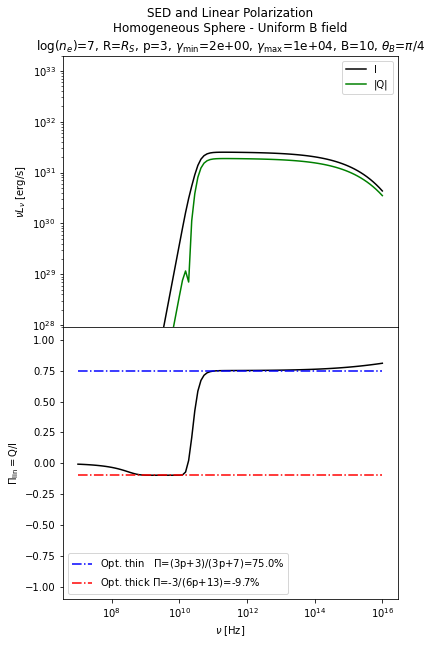

In [4]:
f, axs = plt.subplots(2,1, figsize=(6,10), sharex=True)
f.subplots_adjust(hspace=0)
axs[0].set_title("SED and Linear Polarization\n" + \
                 "Homogeneous Sphere - Uniform B field\n" + \
                r"log($n_e$)=%d, R=$R_S$, p=%d, $\gamma_{\min}$=%1.0e, $\gamma_{\max}$=%1.0e, B=%d, $\theta_B$=$\pi$/4" % 
                 (np.log10(ne), p, gamma_min, gamma_max, B))
axs[0].loglog(nu, I[:]*nu, 'k-', label="I")
axs[0].loglog(nu, np.abs(Q[:])*nu, 'g-', label="|Q|")
axs[0].set_ylim([9e27, 2e33])
axs[0].set_ylabel(r"$\nu L_{\nu}$ [erg/s]")
axs[0].legend()
axs[1].semilogx(nu, Q[:]/I[:], 'k-')
axs[1].semilogx(nu, (3*p+3)/(3*p+7)+np.zeros_like(nu), 'b-.', label=r"Opt. thin   $\Pi$=(3p+3)/(3p+7)=%.1f%%" % 
                    ((3*p+3)/(3*p+7)*100))
axs[1].semilogx(nu, -3/(6*p+13)+np.zeros_like(nu), 'r-.', label=r"Opt. thick $\Pi$=-3/(6p+13)=%.1f%%" % 
               (-3/(6*p+13)*100))
axs[1].set_ylim([-1.1, 1.1])
axs[1].set_ylabel(r"$\Pi_{\mathrm{lin}}=\mathrm{Q}/\mathrm{I}$")
axs[1].set_xlabel(r"$\nu$ [Hz]")
axs[1].legend()